In [4]:
import datetime
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
import os
import pandas as pd
import scipy.stats
from scipy.interpolate import make_smoothing_spline
from sklearn.preprocessing import robust_scale
from sklearn.preprocessing import RobustScaler

In [6]:
print(os.getcwd())

/run/media/bitwalk/DATA/MyProjects/stock-explorer/jupyter


In [7]:
path = '../tmp'
ticker = '8035'
date = '2024-06-04'
pkl = '%s/%s_%s.pkl' % (path, ticker, date)
df = pd.read_pickle(pkl)
df

,Price
2024-06-04 09:00:04,34220.0
2024-06-04 09:00:11,34190.0
2024-06-04 09:00:17,34220.0
2024-06-04 09:00:21,34210.0
2024-06-04 09:00:29,34260.0
...,...
2024-06-04 14:59:41,34430.0
2024-06-04 14:59:46,34410.0
2024-06-04 14:59:53,34410.0
2024-06-04 14:59:58,34380.0


In [8]:
date_str = str(df.index[0].date())
t_start_1 = pd.to_datetime(date_str + ' 09:00:00')
t_start_2 = pd.to_datetime(date_str + ' 10:00:00')
t_mid = pd.to_datetime(date_str + ' 12:00:00')
print(type(t_mid))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [9]:
df1 = df.loc[df.index[df.index < t_mid]]
df2 = df.loc[df.index[df.index > t_mid]]

In [10]:
df11 = df1.copy()
df11.index = [(t - t_start_1).total_seconds() for t in df1.index]
df11

,Price
4.0,34220.0
11.0,34190.0
17.0,34220.0
21.0,34210.0
29.0,34260.0
...,...
8970.0,34080.0
8985.0,34080.0
8991.0,34080.0
8998.0,34070.0


In [11]:
df21 = df2.copy()
df21.index = [(t - t_start_2).total_seconds() for t in df2.index]
df21

,Price
9004.0,34140.0
9011.0,34160.0
9016.0,34150.0
9022.0,34180.0
9029.0,34170.0
...,...
17981.0,34430.0
17986.0,34410.0
17993.0,34410.0
17998.0,34380.0


In [12]:
df3 = pd.concat([df11, df21])
df3

,Price
4.0,34220.0
11.0,34190.0
17.0,34220.0
21.0,34210.0
29.0,34260.0
...,...
17981.0,34430.0
17986.0,34410.0
17993.0,34410.0
17998.0,34380.0


In [13]:
dict_data = dict()
n = len(df3)
for idx in range(n):
    series = df3.iloc[idx]
    value = series.iloc[0]
    key = series.name
    dict_data[key] = value

In [14]:
df0 = pd.DataFrame({'Price': dict_data.values()}, index=dict_data.keys())
df0

,Price
4.0,34220.0
11.0,34190.0
17.0,34220.0
21.0,34210.0
29.0,34260.0
...,...
17981.0,34430.0
17986.0,34410.0
17993.0,34410.0
17998.0,34380.0


In [15]:
x = np.array(df0.index)
# y = scipy.stats.zscore(df0['Price'])
y = np.array([y for y in robust_scale(df0['Price'])])
y

array([0.11111111, 0.        , 0.11111111, ..., 0.81481481, 0.7037037 ,
       1.        ])

In [21]:
t_start_0 = 0
t_end_0 = 18000
t_interval_0 = 10

spl = make_smoothing_spline(x, y)
xs = np.linspace(t_start_0, t_end_0, int((t_end_0 - t_start_0) / t_interval_0))
len(xs)

1800

In [22]:
# _____________________________________________________________________
# Integrals for Morning and Afternoon
count = 0
sum_morning = 0
sum_afternoon = 0
for h in spl(xs):
    if count < len(xs) / 2:
        sum_morning += h
    else:
        sum_afternoon += h
    count += 1
print('Area = %d, %d' % (round(sum_morning), round(sum_afternoon)))

Area = -218, 546


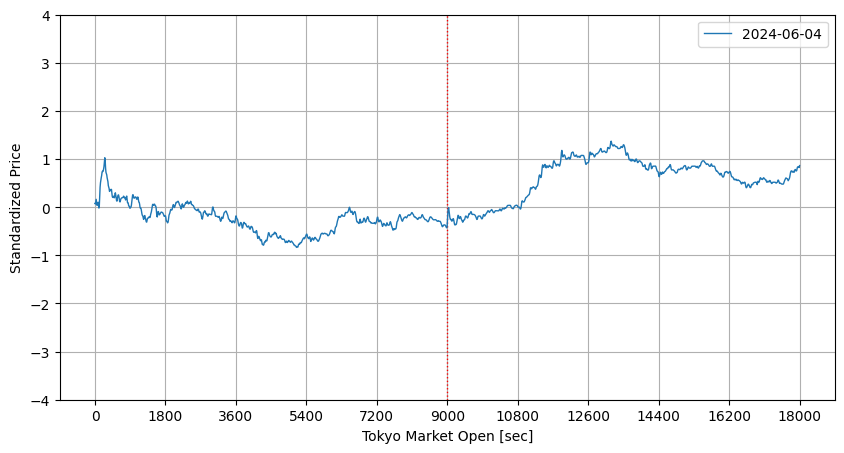

In [23]:
plt.rcParams["figure.figsize"] = (10, 5)
fig, ax = plt.subplots()

ax.axvline(x=9000, linestyle='dotted', lw=1, c='red')

ax.set_xlabel('Tokyo Market Open [sec]')
ax.set_ylabel('Standardized Price')

ax.xaxis.set_ticks(np.arange(0, 18001, 1800))
ax.set_ylim(-4, 4)

#ax.scatter(x, y, s=1, c='gray')
ax.plot(xs, spl(xs), lw=1, label=date)
ax.grid()
ax.legend(loc='best')

plt.show()

# Calculate median and IQR for scaling

In [107]:
y_raw = np.array(df0['Price'])
y_median = np.median(y_raw)
iqr = np.subtract(*np.percentile(y_raw, [75, 25]))
print(y_median, iqr)

33580.0 140.0


In [108]:
y = np.array([(v - y_median) / iqr for v in y_raw])
y

array([ 4.92857143,  5.64285714,  5.07142857, ..., -0.85714286,
       -0.78571429, -0.28571429])

In [109]:
spl = make_smoothing_spline(x, y)
xs = np.linspace(t_start_0, t_end_0, int((t_end_0 - t_start_0) / t_interval_0))
type(spl(xs))

numpy.ndarray

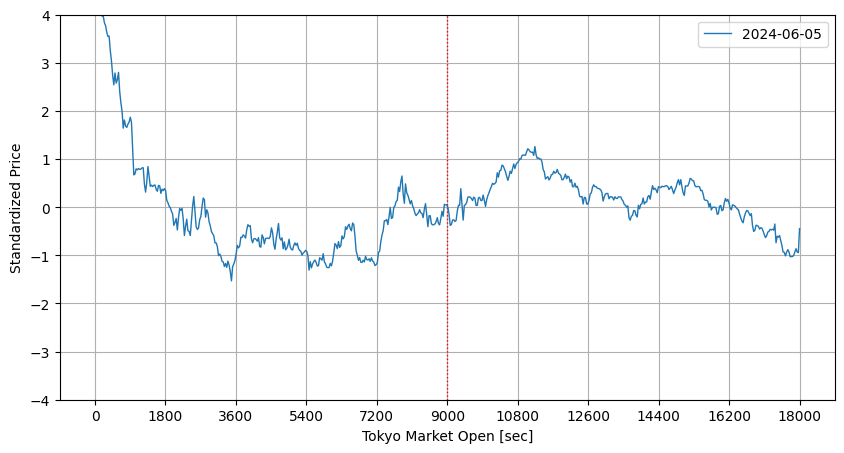

In [110]:
plt.rcParams["figure.figsize"] = (10, 5)
fig, ax = plt.subplots()

ax.axvline(x=9000, linestyle='dotted', lw=1, c='red')

ax.set_xlabel('Tokyo Market Open [sec]')
ax.set_ylabel('Standardized Price')

ax.xaxis.set_ticks(np.arange(0, 18001, 1800))
ax.set_ylim(-4, 4)

#ax.scatter(x, y, s=1, c='gray')
ax.plot(xs, spl(xs), lw=1, label=date)
ax.grid()
ax.legend(loc='best')

plt.show()